GAN MODEL for Generating Faces from Masked Image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import Sequence

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, Flatten, Reshape, Dense, add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import cv2
import random, math

# Load Preprocessed Train and Test Set

In [ ]:
x_train = np.load("/content/drive/MyDrive/CV/X_rgb_128_train.npy")
y_train = np.load("/content/drive/MyDrive/CV/Y_rgb_128_train.npy")
x_test = np.load("/content/drive/MyDrive/CV/X_rgb_128_test.npy")
y_test = np.load("/content/drive/MyDrive/CV/Y_rgb_128_test.npy")

x_train.shape,y_train.shape, x_test.shape, y_test.shape

((4000, 128, 128, 3),
 (4000, 128, 128, 3),
 (398, 128, 128, 3),
 (398, 128, 128, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

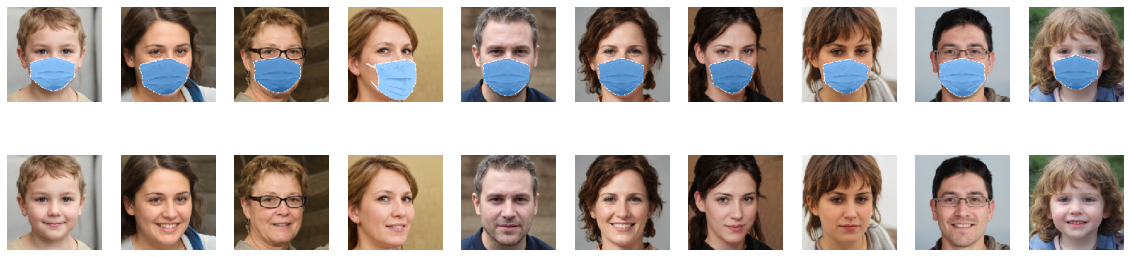

In [ ]:
plt.figure(figsize=(20,5))
masks = x_test[:10]
nomasks = y_test[:10]
for i, (x,y) in enumerate(zip(masks[:10],nomasks[:10])):
    plt.subplot(2,10,i+1)
    plt.imshow(x)
    plt.axis("OFF")
    
    plt.subplot(2,10,i+11)
    plt.imshow(y)
    plt.axis("OFF")
plt.show()

# Data Augmentation

In [ ]:
class Daugmentation:
    def flip(img, t):
        if t[0]==0:
            return img
        else:
            return cv2.flip(img, t[1])

    def zoom(img, t):
        if t[2]==0:
            return img
        else:
            h, w = img.shape[:2]
            nh, nw =  int(t[3]*h), int(t[3]*w)
            dh, dw = h-nh, w-nw
            zimg = img[dh//2:nh+dh//2, dw//2:nw+dw//2]
            zimg = cv2.resize(zimg, (w,h))
            return zimg


    def get_ts(batch_size):
        return [[random.choice([0,1]),random.choice([-1,0,1]), random.randint(0,2),random.uniform(0.4,0.9)] for i in range(batch_size)]

    def aug(img,t):
        img = Daugmentation.flip(img,t)
        # img = Daugmentation.zoom(img, t)
        return img


class maSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, Daugmentation):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = Daugmentation

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        ts = self.augment.get_ts(len(batch_x))
        return np.array([self.augment.aug(x,t) for x,t in zip(batch_x,ts)]),np.array([self.augment.aug(y,t) for y,t in zip(batch_y,ts)]) 

In [ ]:
batch_size=16

gotrain = maSequence(x_train, y_train, batch_size,Daugmentation)
gotest = maSequence(x_test, y_test, batch_size,Daugmentation)

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#x_test = x_test[:,:,:,0]
#x_train = x_train[:,:,:,0]
#y_test = y_test[:,:,:,0]
#y_train = y_train[:,:,:,0]

# Model Building and Training

In [ ]:
def get_model():
    # encoder
    In = Input(shape=x_train[0].shape)
    c1 = Conv2D(32, 3, activation="relu", padding="same")(In)
    c1 = Conv2D(32, 3, activation="relu", padding="same")(c1)

    m1 = MaxPooling2D(2)(c1)
    c2 = Conv2D(64, 3, activation="relu", padding="same")(m1)
    c2 = Conv2D(64, 3, activation="relu", padding="same")(c2)

    m2 = MaxPooling2D(2)(c2)
    c3 = Conv2D(128, 3, activation="relu", padding="same")(m2)
    c3 = Conv2D(128, 3, activation="relu", padding="same")(c3)

    m3 = MaxPooling2D(2)(c3)
    c4 = Conv2D(256, 3, activation="relu", padding="same")(m3)
    c4 = Conv2D(256, 3, activation="relu", padding="same")(c4)

    u1 = Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(c4)
    c5 = Conv2D(128, 3, activation="relu", padding="same")(u1)
    c5 = Conv2D(128, 3, activation="relu", padding="same")(c5)

    a1 = add([c5,c3])
    u2 = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(a1)
    c6 = Conv2D(64, 3, activation="relu", padding="same")(u2)
    c6 = Conv2D(64, 3, activation="relu", padding="same")(c6)

    a2 = add([c6,c2])
    u3 = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(a2)
    c7 = Conv2D(32, 3, activation="relu", padding="same")(u3)
    c7 = Conv2D(32, 3, activation="relu", padding="same")(c7)

    a3 = add([c7,c1])
    Out = Conv2D(3, 3, activation="sigmoid", padding="same")(a3)
    
    model = Model(In,Out)
    adam = keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=adam,loss="binary_crossentropy",metrics=['accuracy'])
    return model

model = get_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 128, 128, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_31 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_30[0][0]']              
                                )                                                           

In [ ]:
with tf.device('/device:GPU:0'):
  checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/CV/best_final.h5', verbose=0, save_best_only=True)
  history = model.fit_generator(generator=gotrain,
                                steps_per_epoch=gotrain.__len__(),
                                epochs=100,
                                
                                callbacks=[checkpointer],
                                validation_data=gotest,
                                validation_steps=gotest.__len__())

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


225/225 [==============================] - 31s 131ms/step - loss: 0.5879 - accuracy: 0.8625 - val_loss: 0.5734 - val_accuracy: 0.8920
Epoch 2/100
225/225 [==============================] - 17s 77ms/step - loss: 0.5717 - accuracy: 0.9237 - val_loss: 0.5701 - val_accuracy: 0.9276
Epoch 3/100
225/225 [==============================] - 18s 78ms/step - loss: 0.5697 - accuracy: 0.9433 - val_loss: 0.5689 - val_accuracy: 0.9520
Epoch 4/100
225/225 [==============================] - 17s 76ms/step - loss: 0.5689 - accuracy: 0.9479 - val_loss: 0.5683 - val_accuracy: 0.9495
Epoch 5/100
225/225 [==============================] - 17s 77ms/step - loss: 0.5684 - accuracy: 0.9502 - val_loss: 0.5680 - val_accuracy: 0.9480
Epoch 6/100
225/225 [==============================] - 17s 77ms/step - loss: 0.5680 - accuracy: 0.9535 - val_loss: 0.5679 - val_accuracy: 0.9456
Epoch 7/100
225/225 [==============================] - 17s 78ms/step - loss: 0.5677 - accuracy: 0.9531 - val_loss: 0.5675 - val_accuracy: 0.9

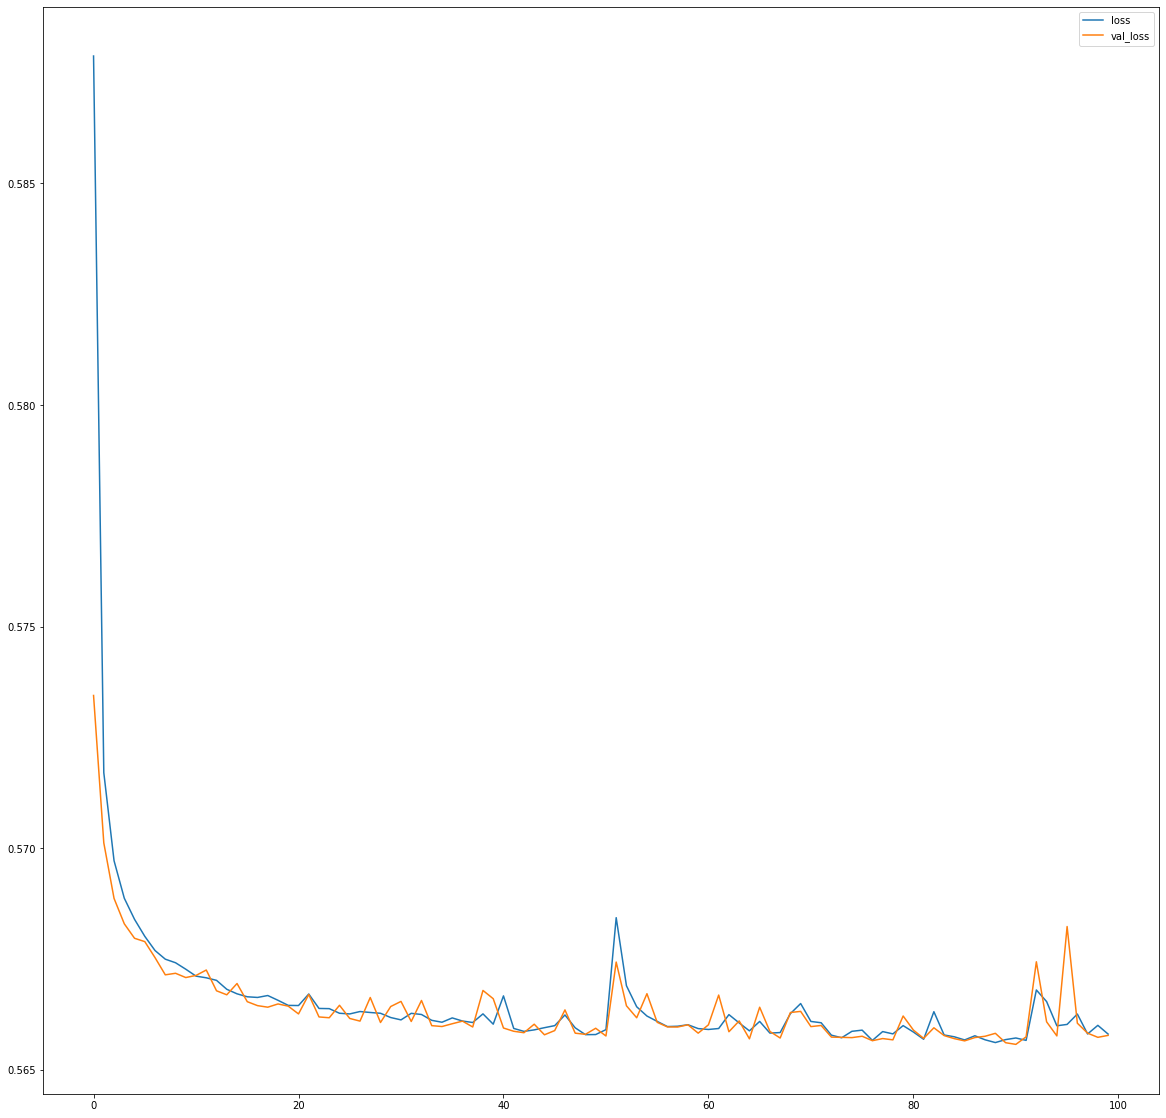

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss","val_loss"])
plt.show()

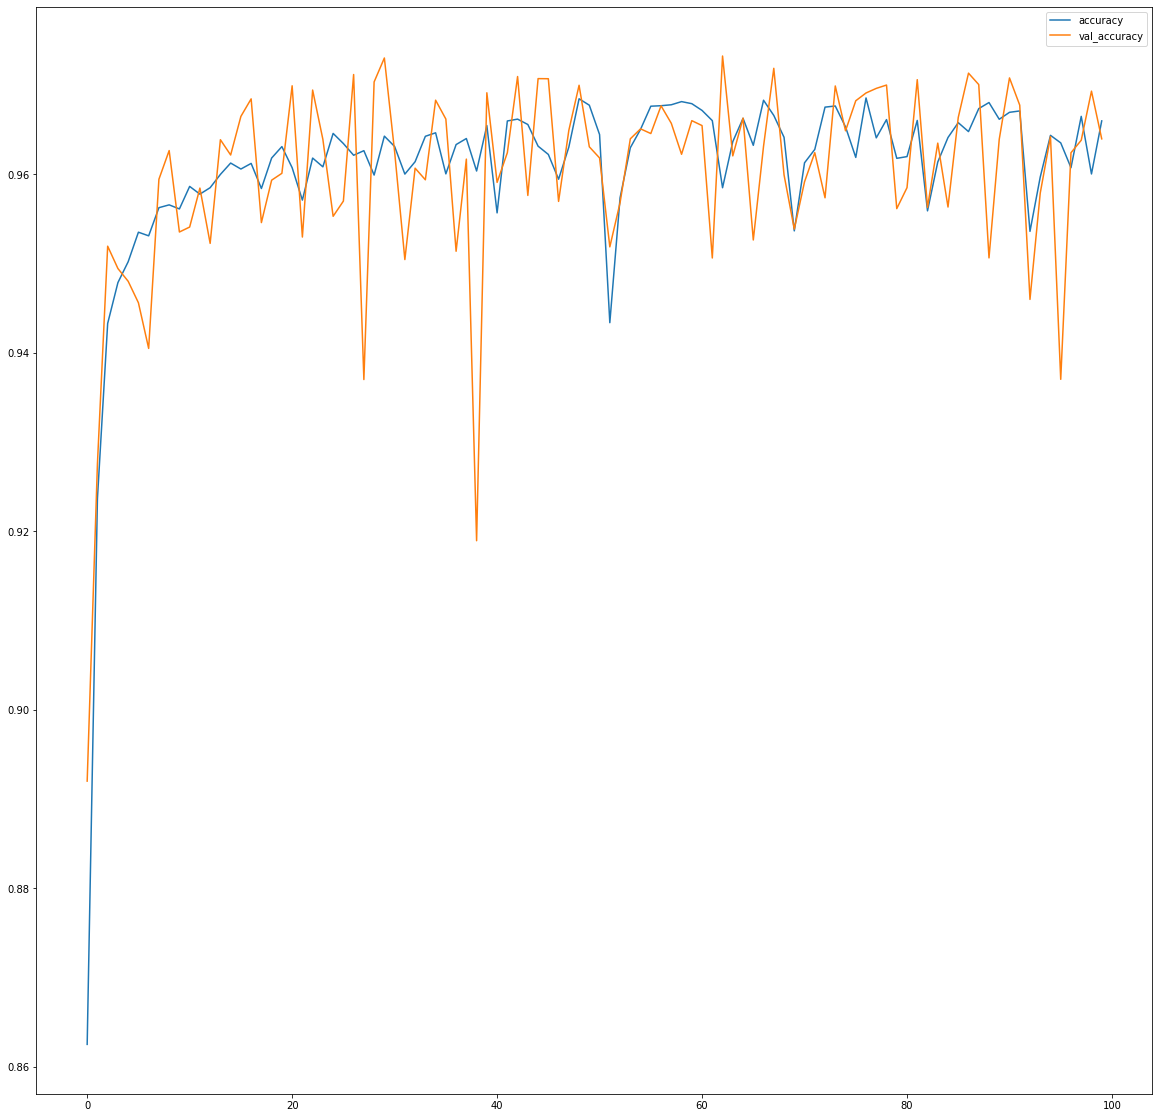

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy","val_accuracy"])
plt.show()

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/CV/best_final.h5")

In [ ]:
import tensorflow as tf
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0001)
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/CV/best_rgb_final_1.h5', verbose=0, monitor='val_loss',
    mode='min', save_best_only=True)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

with tf.device('/device:GPU:0'):
  
  history = model.fit_generator(generator=gotrain,
                                steps_per_epoch=gotrain.__len__(),
                                epochs=50,
                                
                                callbacks=[checkpointer,reduce_lr,callback],
                                validation_data=gotest,
                                validation_steps=gotest.__len__())

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


250/250 [==============================] - 53s 208ms/step - loss: 0.5919 - accuracy: 0.8669 - val_loss: 0.5734 - val_accuracy: 0.8841 - lr: 0.0020
Epoch 2/50
250/250 [==============================] - 52s 208ms/step - loss: 0.5741 - accuracy: 0.9048 - val_loss: 0.5680 - val_accuracy: 0.9345 - lr: 0.0020
Epoch 3/50
250/250 [==============================] - 52s 207ms/step - loss: 0.5706 - accuracy: 0.9364 - val_loss: 0.5667 - val_accuracy: 0.9544 - lr: 0.0020
Epoch 4/50
250/250 [==============================] - 52s 207ms/step - loss: 0.5693 - accuracy: 0.9445 - val_loss: 0.5659 - val_accuracy: 0.9532 - lr: 0.0020
Epoch 5/50
250/250 [==============================] - 52s 207ms/step - loss: 0.5690 - accuracy: 0.9453 - val_loss: 0.5656 - val_accuracy: 0.9524 - lr: 0.0020
Epoch 6/50
250/250 [==============================] - 52s 207ms/step - loss: 0.5684 - accuracy: 0.9502 - val_loss: 0.5652 - val_accuracy: 0.9632 - lr: 0.0020
Epoch 7/50
250/250 [==============================] - 52s 207ms

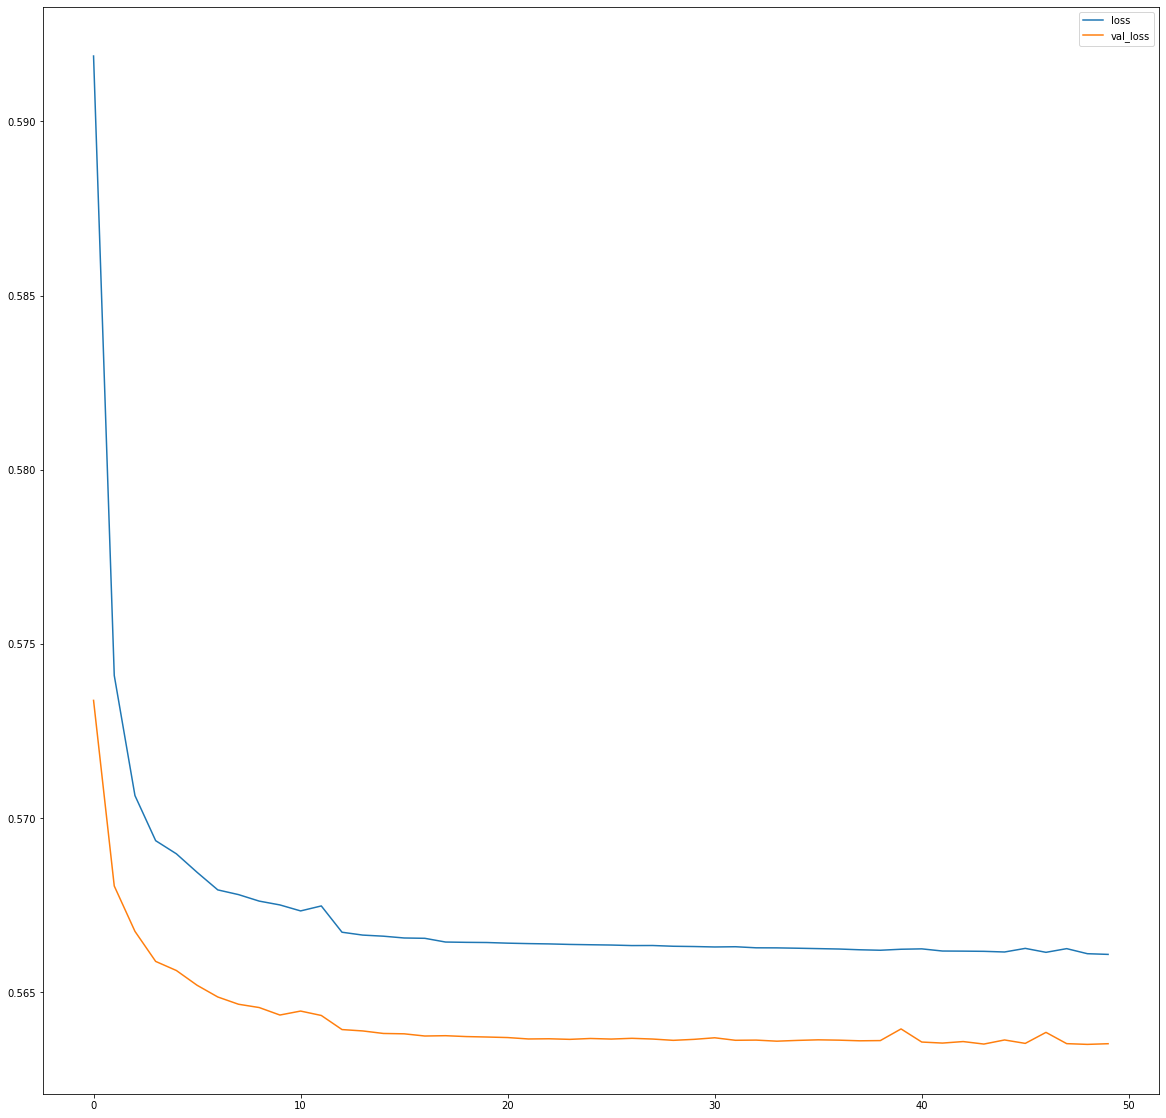

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss","val_loss"])
plt.show()

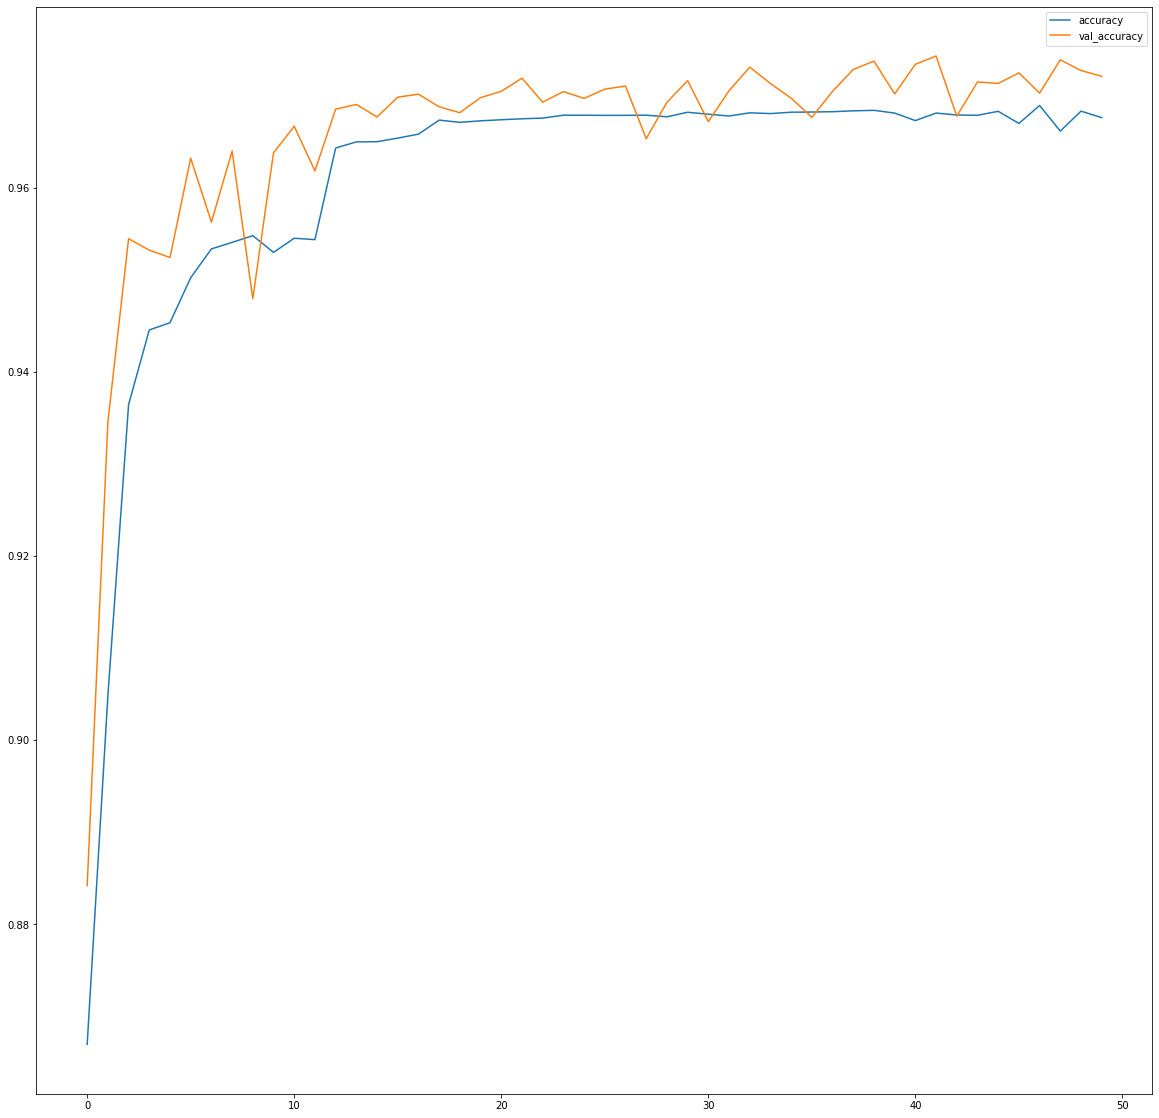

In [ ]:
plt.figure(figsize=(20,20))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy","val_accuracy"])
plt.show()

# Generate Images

In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/CV/best_rgb_final_1.h5")

In [ ]:
x_test.shape

(400, 128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

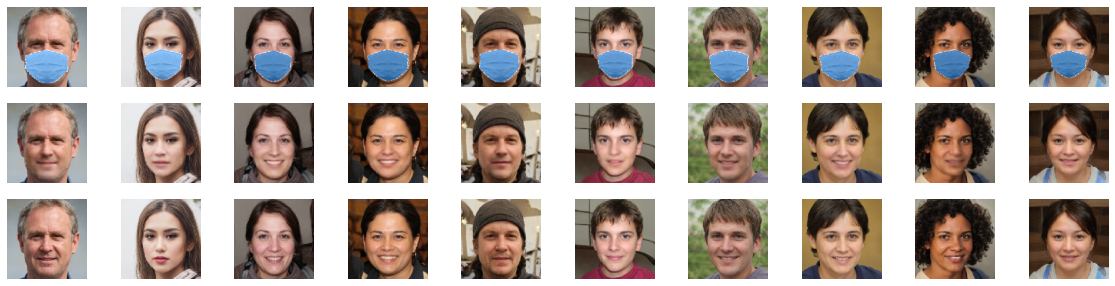

In [ ]:
plt.figure(figsize=(20,5))
masks = x_test[40:50]
nomask_preds = model.predict(masks)
nomask_actuals = y_test[40:50]
for i in range(10):
    plt.subplot(3,10,i+1)
    plt.imshow(masks[i])
    plt.axis("OFF")
    
    plt.subplot(3,10,i+11)
    plt.imshow(nomask_preds[i])
    plt.axis("OFF")
    
    plt.subplot(3,10,i+21)
    plt.imshow(nomask_actuals[i])
    plt.axis("OFF")
plt.show()